In [117]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [57]:
class Model:
    def read_data(self, filename):
        data = pd.read_csv(filename)
        
    def train_model(self):
        pass

In [58]:
data = pd.read_csv("../^BVSP.csv")
data = data.dropna()

In [59]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-04-17,38086.0,38698.0,38086.0,38462.0,38462.0,0.0
1,2006-04-18,38466.0,39584.0,38466.0,39572.0,39572.0,0.0
2,2006-04-19,39581.0,40026.0,39492.0,39938.0,39938.0,0.0
3,2006-04-20,39941.0,40278.0,39435.0,39775.0,39775.0,0.0
5,2006-04-24,39775.0,40089.0,39616.0,39751.0,39751.0,0.0


In [75]:
values = data['Open'].as_matrix().reshape(len(data['Open']), 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [77]:
dataset = values.astype('float32')

In [96]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [82]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2152 1060


In [84]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [85]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [86]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [87]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 5s - loss: 0.0212
Epoch 2/100
 - 3s - loss: 0.0011
Epoch 3/100
 - 5s - loss: 2.5657e-04
Epoch 4/100
 - 5s - loss: 2.4563e-04
Epoch 5/100
 - 5s - loss: 2.2768e-04
Epoch 6/100
 - 4s - loss: 2.1355e-04
Epoch 7/100
 - 3s - loss: 2.0713e-04
Epoch 8/100
 - 4s - loss: 2.0428e-04
Epoch 9/100
 - 4s - loss: 1.9975e-04
Epoch 10/100
 - 4s - loss: 2.0034e-04
Epoch 11/100
 - 4s - loss: 1.9401e-04
Epoch 12/100
 - 4s - loss: 1.9615e-04
Epoch 13/100
 - 4s - loss: 1.9540e-04
Epoch 14/100
 - 3s - loss: 1.9691e-04
Epoch 15/100
 - 3s - loss: 1.9852e-04
Epoch 16/100
 - 3s - loss: 1.9551e-04
Epoch 17/100
 - 3s - loss: 1.9478e-04
Epoch 18/100
 - 3s - loss: 1.9511e-04
Epoch 19/100
 - 3s - loss: 1.9609e-04
Epoch 20/100
 - 3s - loss: 1.9649e-04
Epoch 21/100
 - 3s - loss: 1.9464e-04
Epoch 22/100
 - 3s - loss: 1.9362e-04
Epoch 23/100
 - 3s - loss: 1.9621e-04
Epoch 24/100
 - 3s - lo

In [93]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.02 RMSE


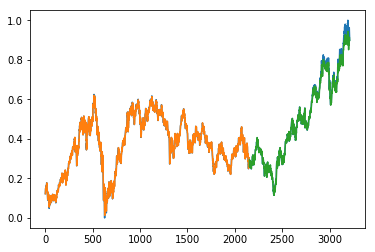

In [95]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [121]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [122]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [124]:
loaded_model.compile(loss='mean_squared_error', optimizer='adam')